In [3]:
import requests

# Raw URL of the Parquet file on GitHub
url = 'https://github.com/FlowFrontiers/IFLforTFC/raw/main/datasets/dataset.parquet'

# Send a GET request to the raw URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the content to a local file with the specified filename
    with open('dataset.parquet', 'wb') as file:
        file.write(response.content)
    print("Parquet file 'dataset.parquet' downloaded successfully!")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

Parquet file 'dataset.parquet' downloaded successfully!



Training Vanilla Autoencoder
Epoch [10/200], Train Loss: 0.1295, Test Loss: 0.1504
Epoch [20/200], Train Loss: 0.0619, Test Loss: 0.0830
Epoch [30/200], Train Loss: 0.0542, Test Loss: 0.0561
Epoch [40/200], Train Loss: 0.0266, Test Loss: 0.0243
Epoch [50/200], Train Loss: 0.0137, Test Loss: 0.0112
Epoch [60/200], Train Loss: 0.0129, Test Loss: 0.0122
Epoch [70/200], Train Loss: 0.0070, Test Loss: 0.0070
Epoch [80/200], Train Loss: 0.0043, Test Loss: 0.0048
Epoch [90/200], Train Loss: 0.0027, Test Loss: 0.0026
Epoch [100/200], Train Loss: 0.0025, Test Loss: 0.0024
Epoch [110/200], Train Loss: 0.0022, Test Loss: 0.0022
Epoch [120/200], Train Loss: 0.0021, Test Loss: 0.0021
Epoch [130/200], Train Loss: 0.0021, Test Loss: 0.0020
Epoch [140/200], Train Loss: 0.0020, Test Loss: 0.0020
Epoch [150/200], Train Loss: 0.0019, Test Loss: 0.0019
Epoch [160/200], Train Loss: 0.0019, Test Loss: 0.0019
Epoch [170/200], Train Loss: 0.0018, Test Loss: 0.0018
Epoch [180/200], Train Loss: 0.0018, Test Lo

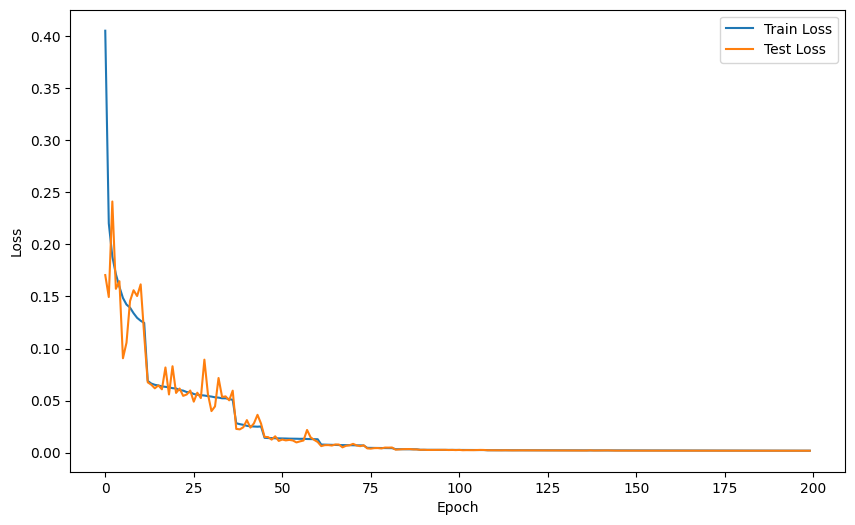

<Figure size 1200x800 with 0 Axes>

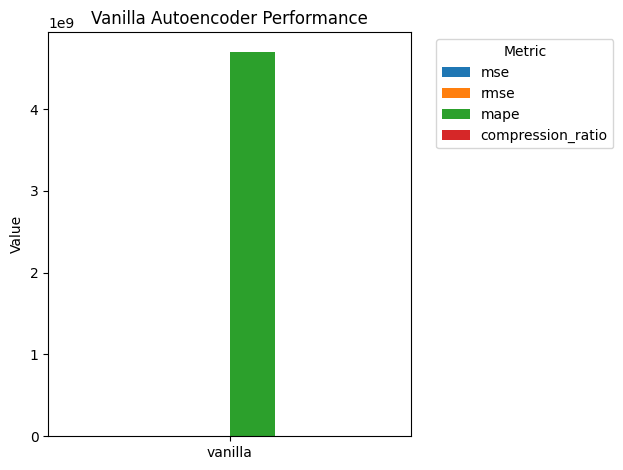

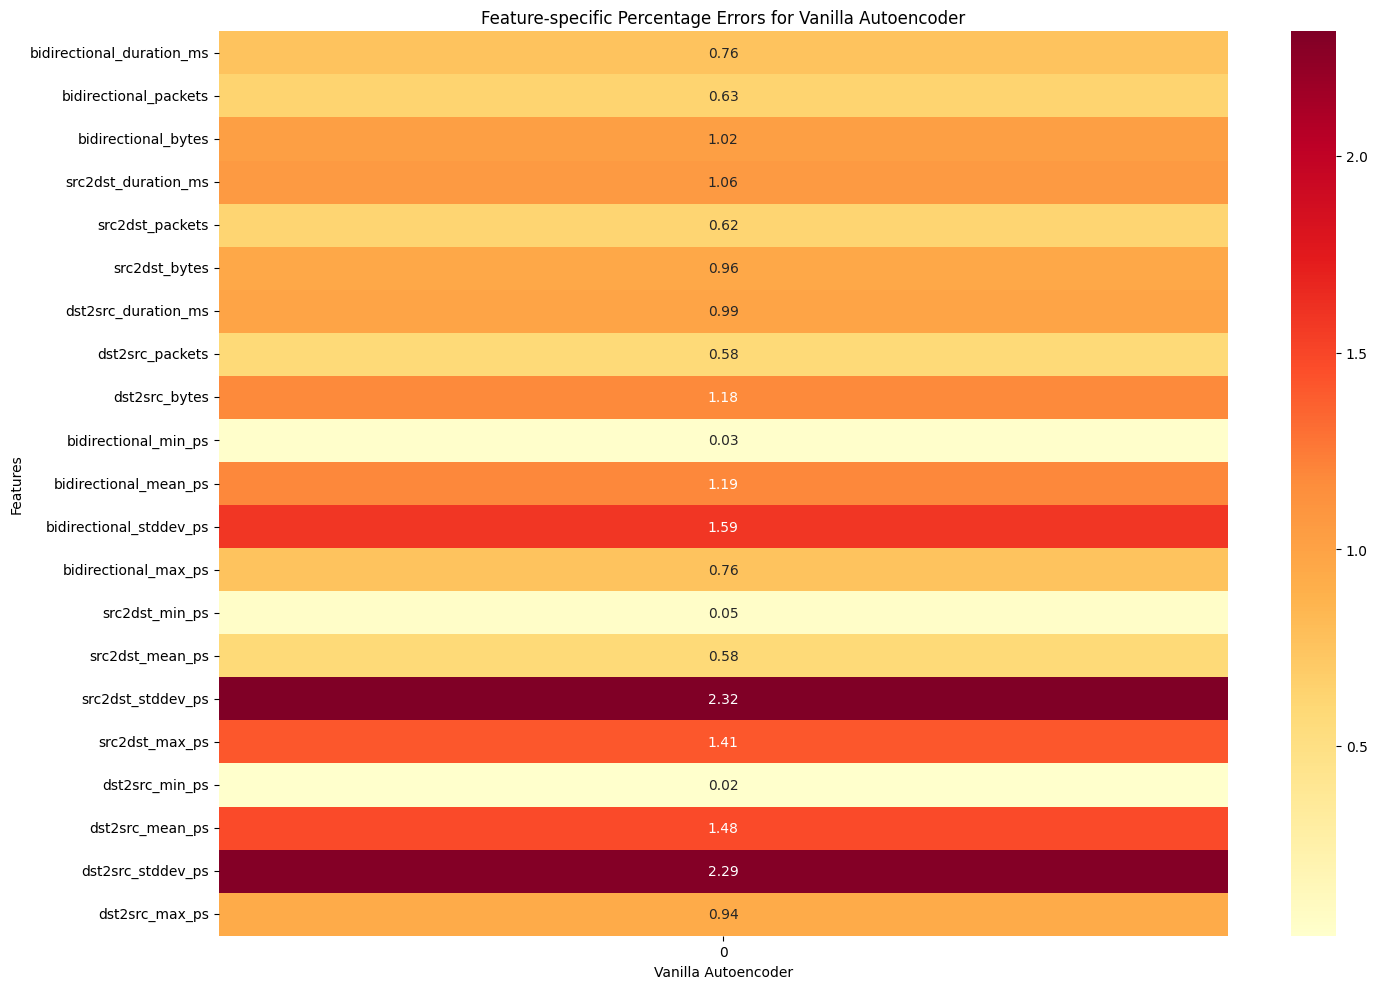

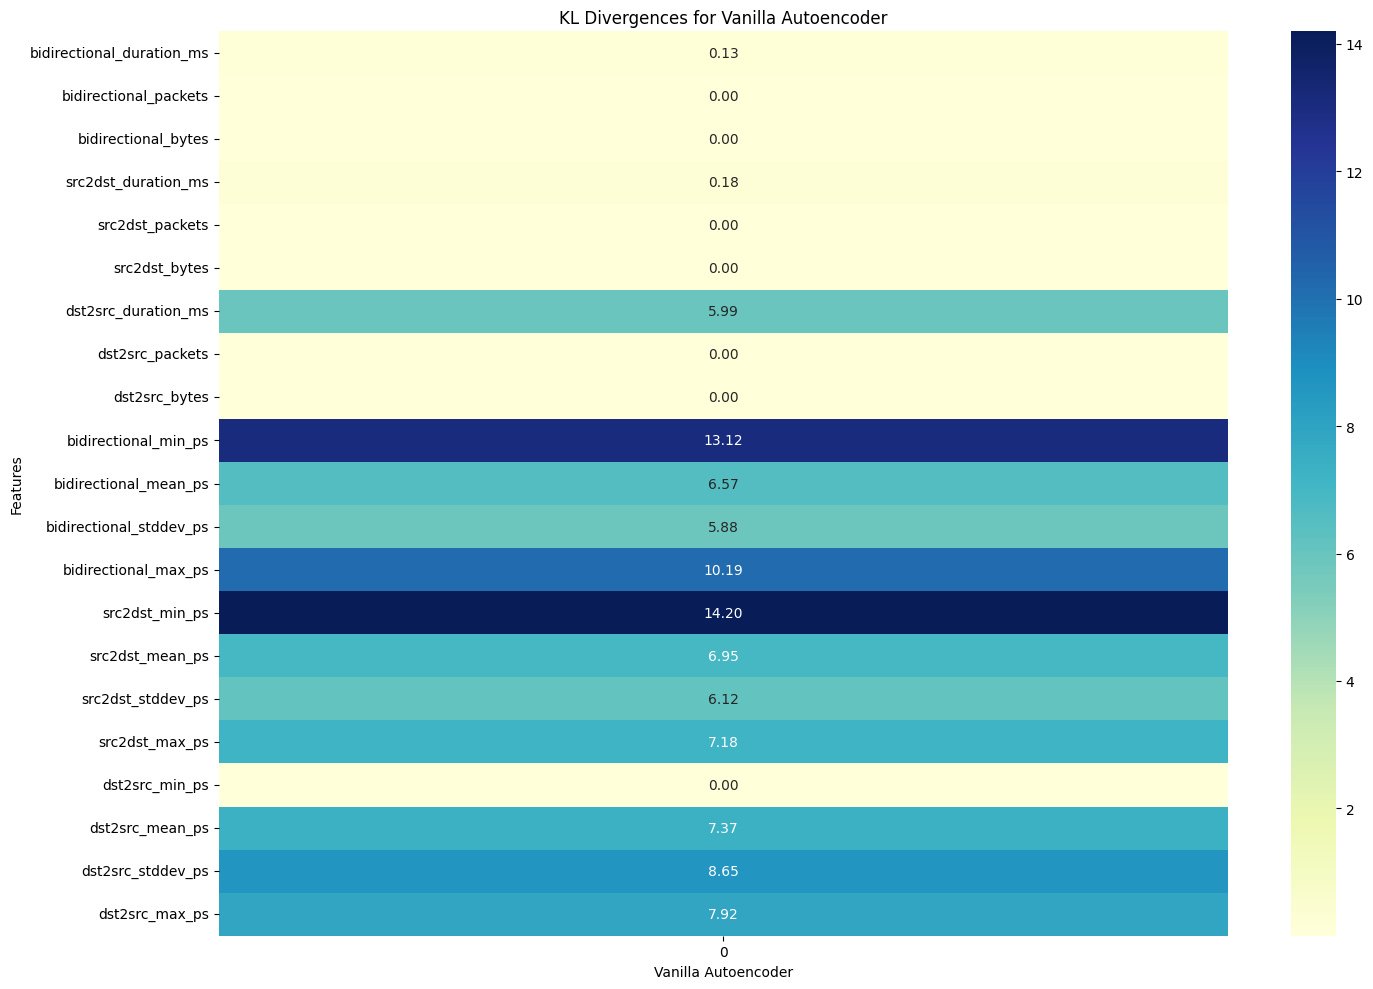

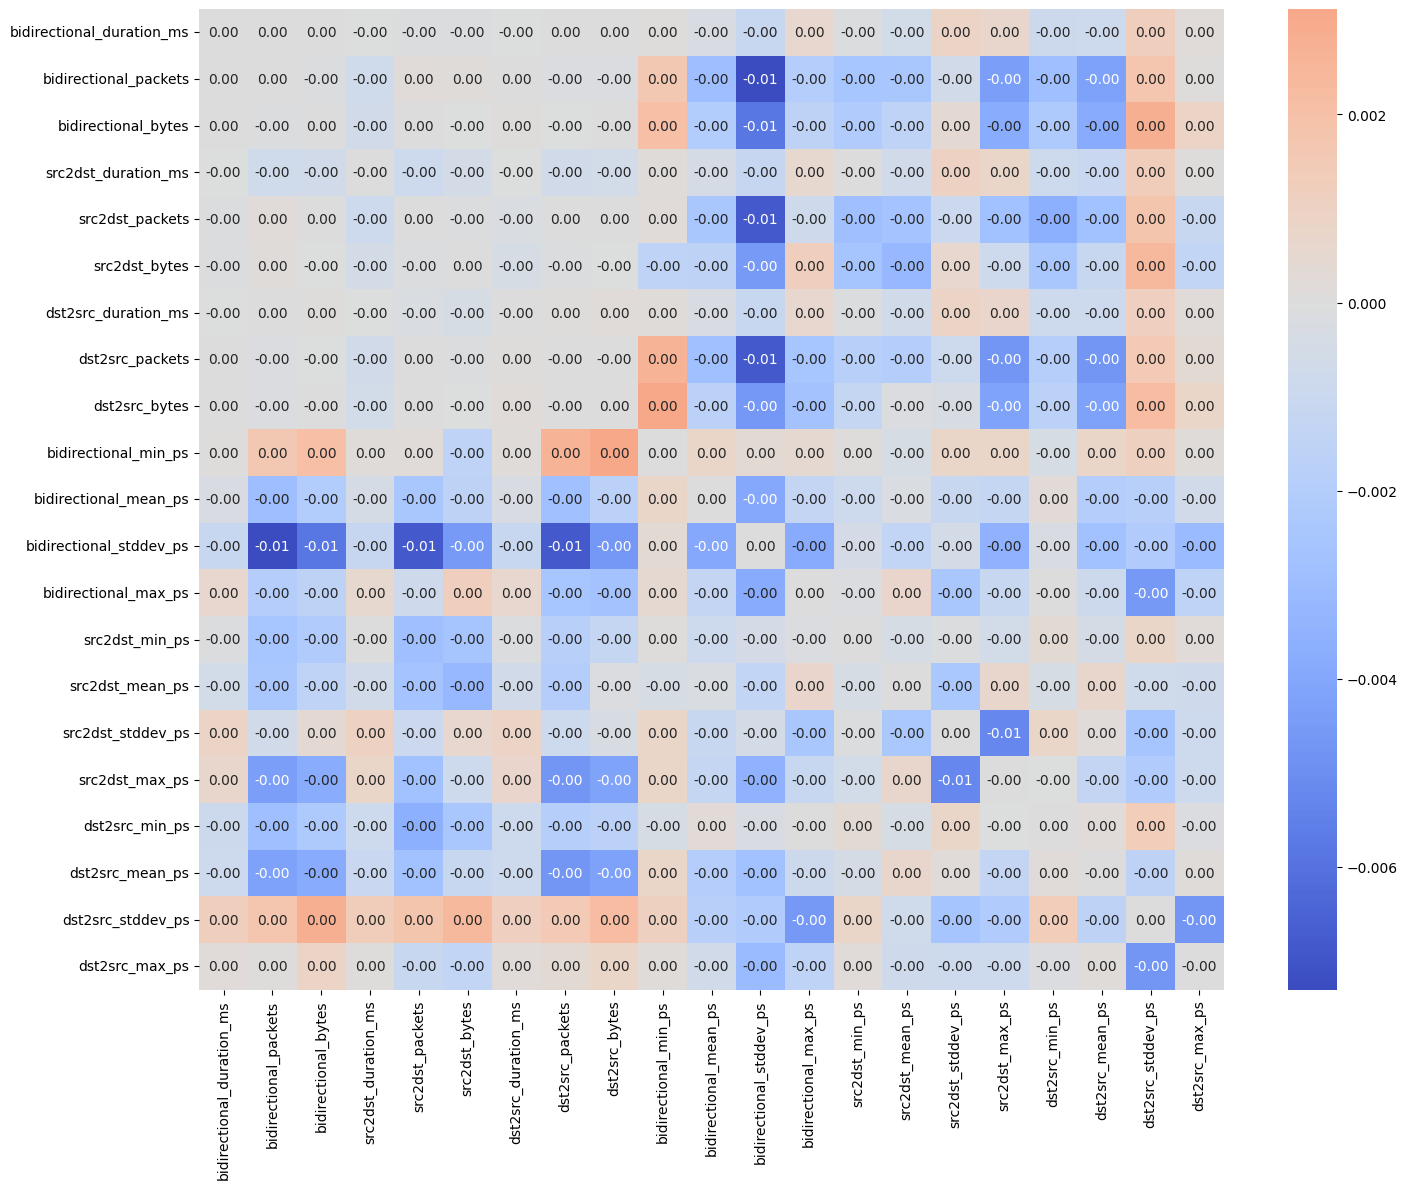

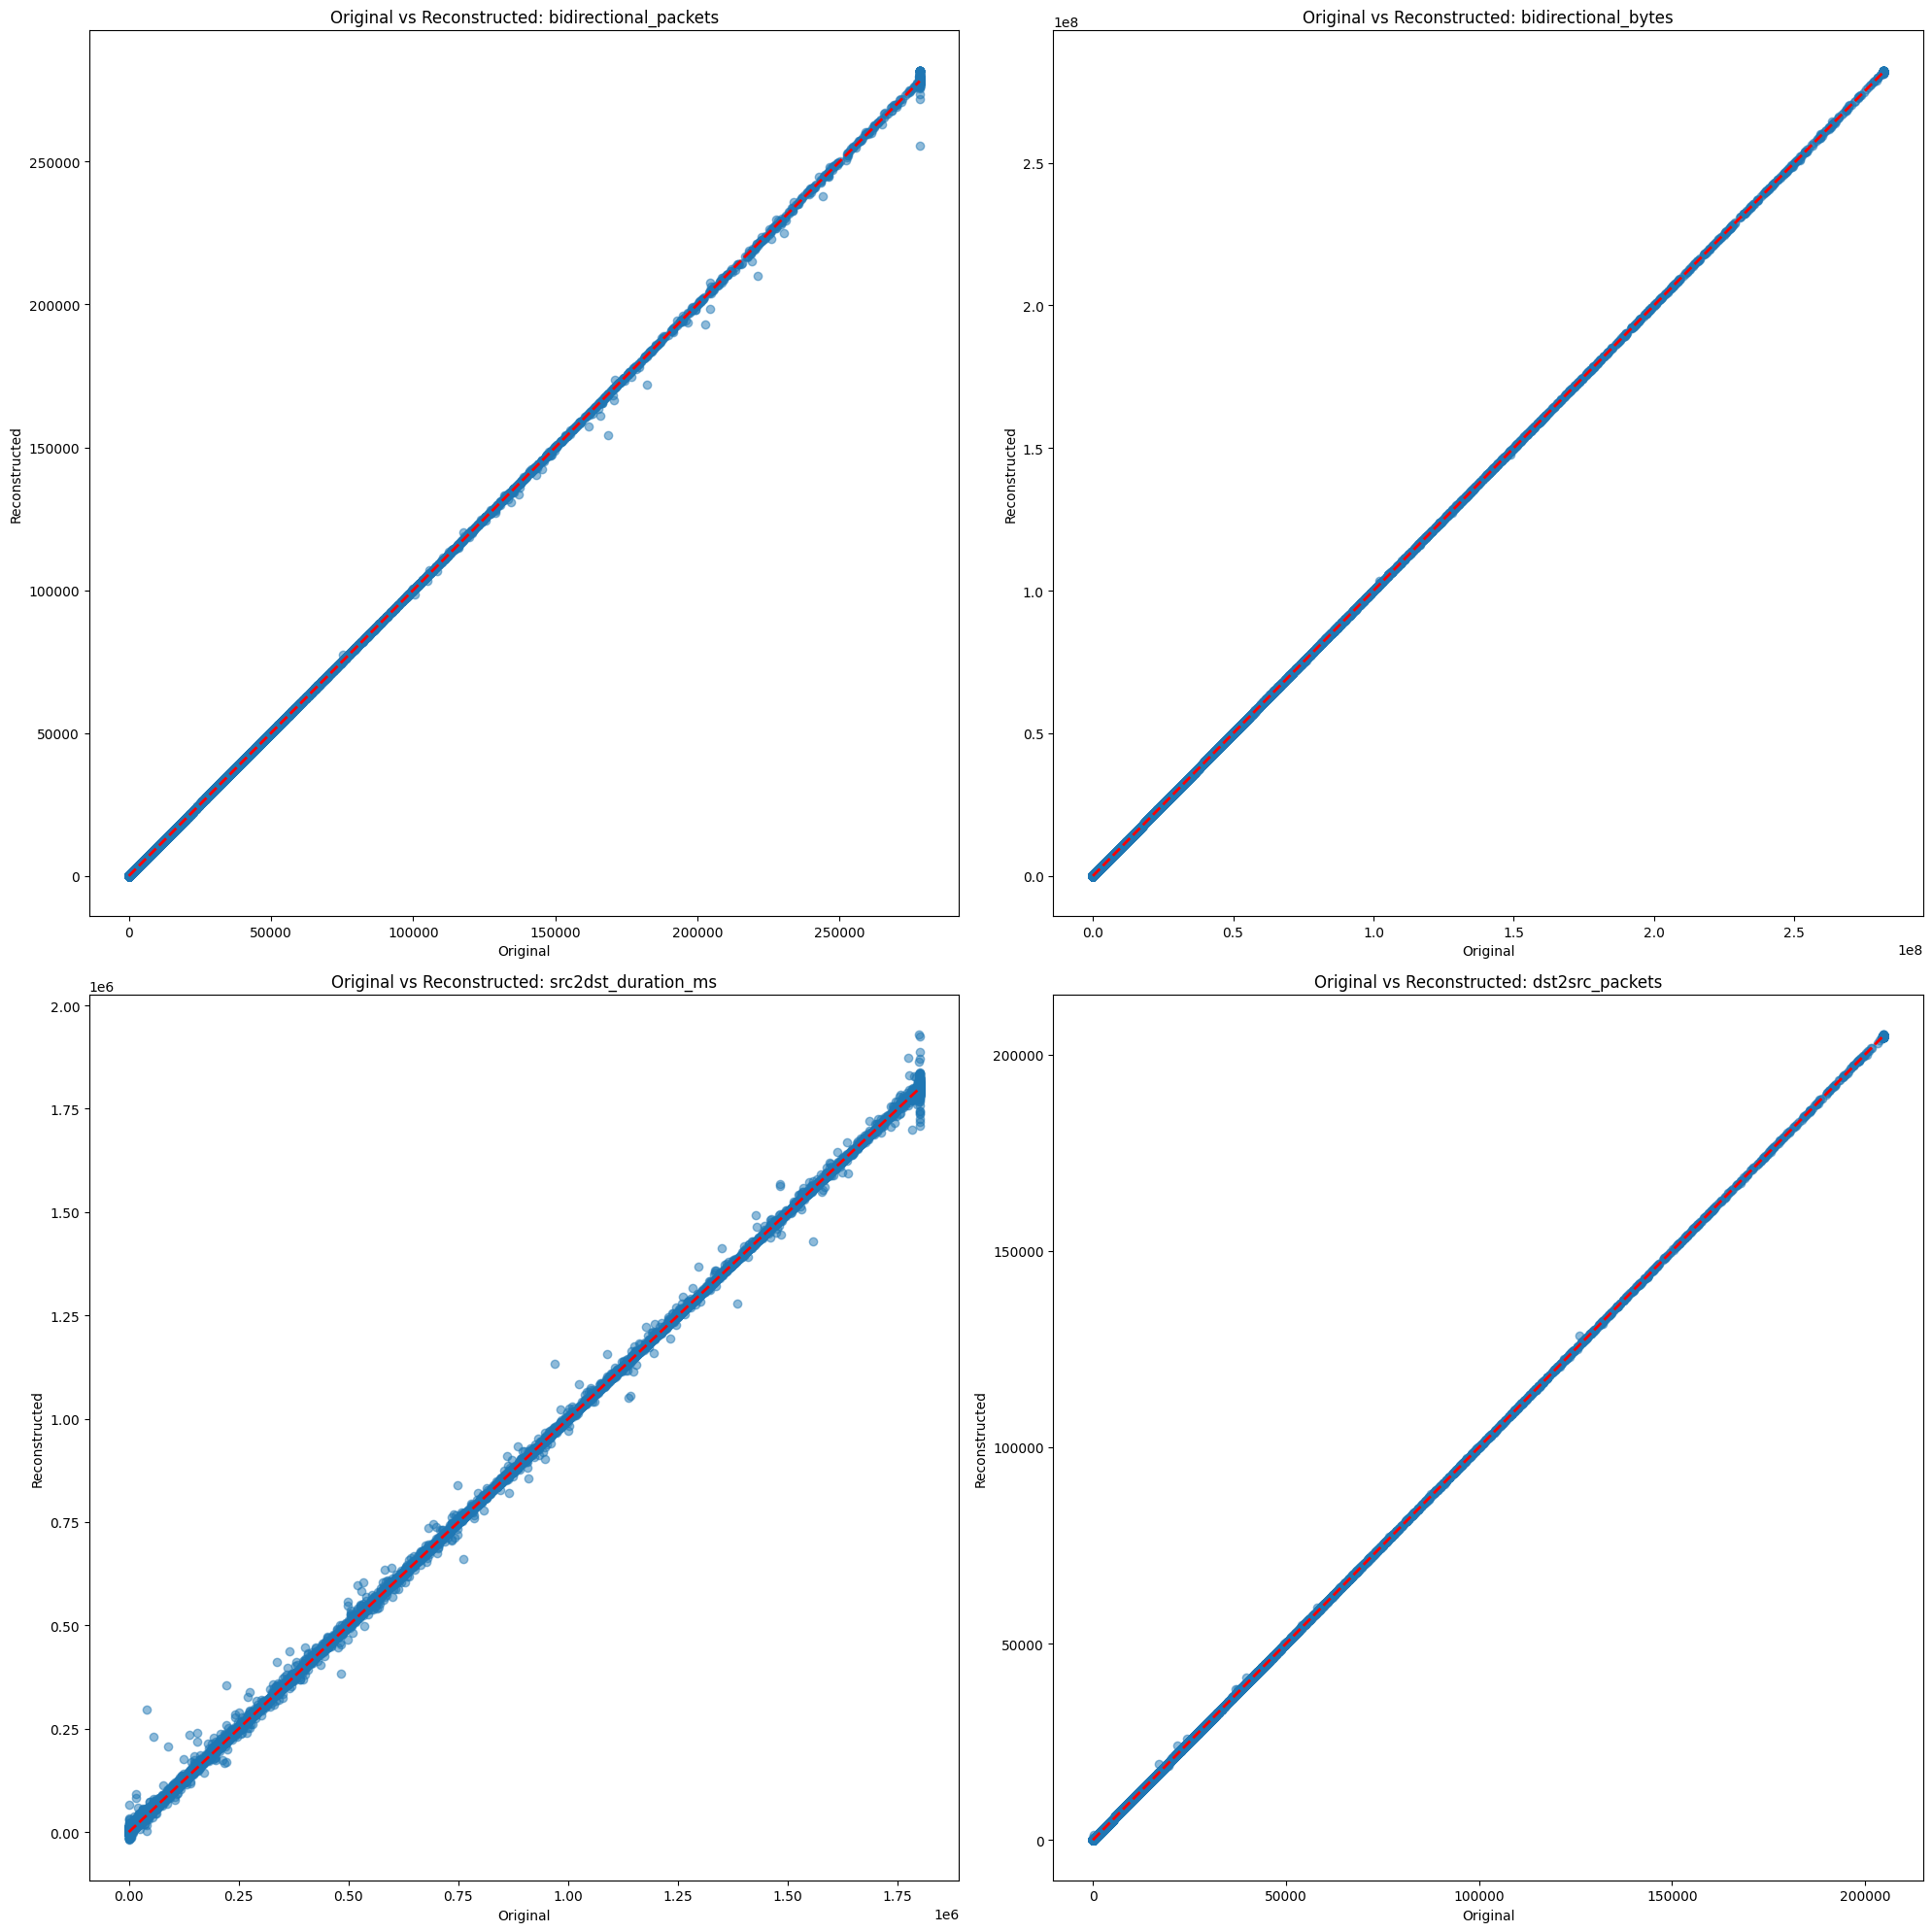

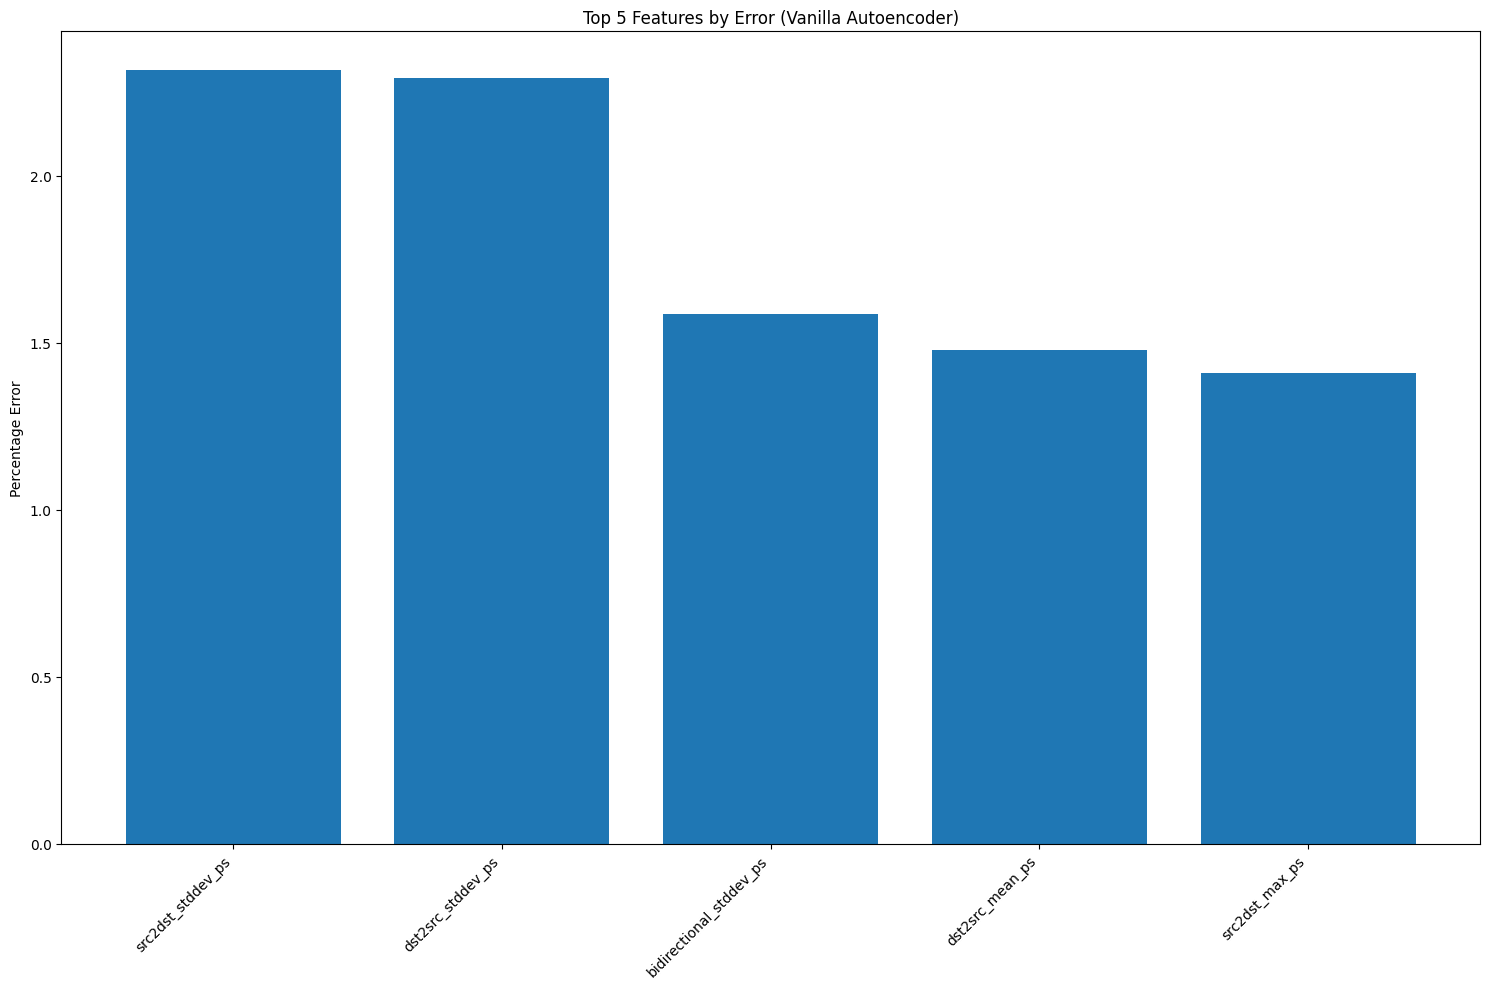

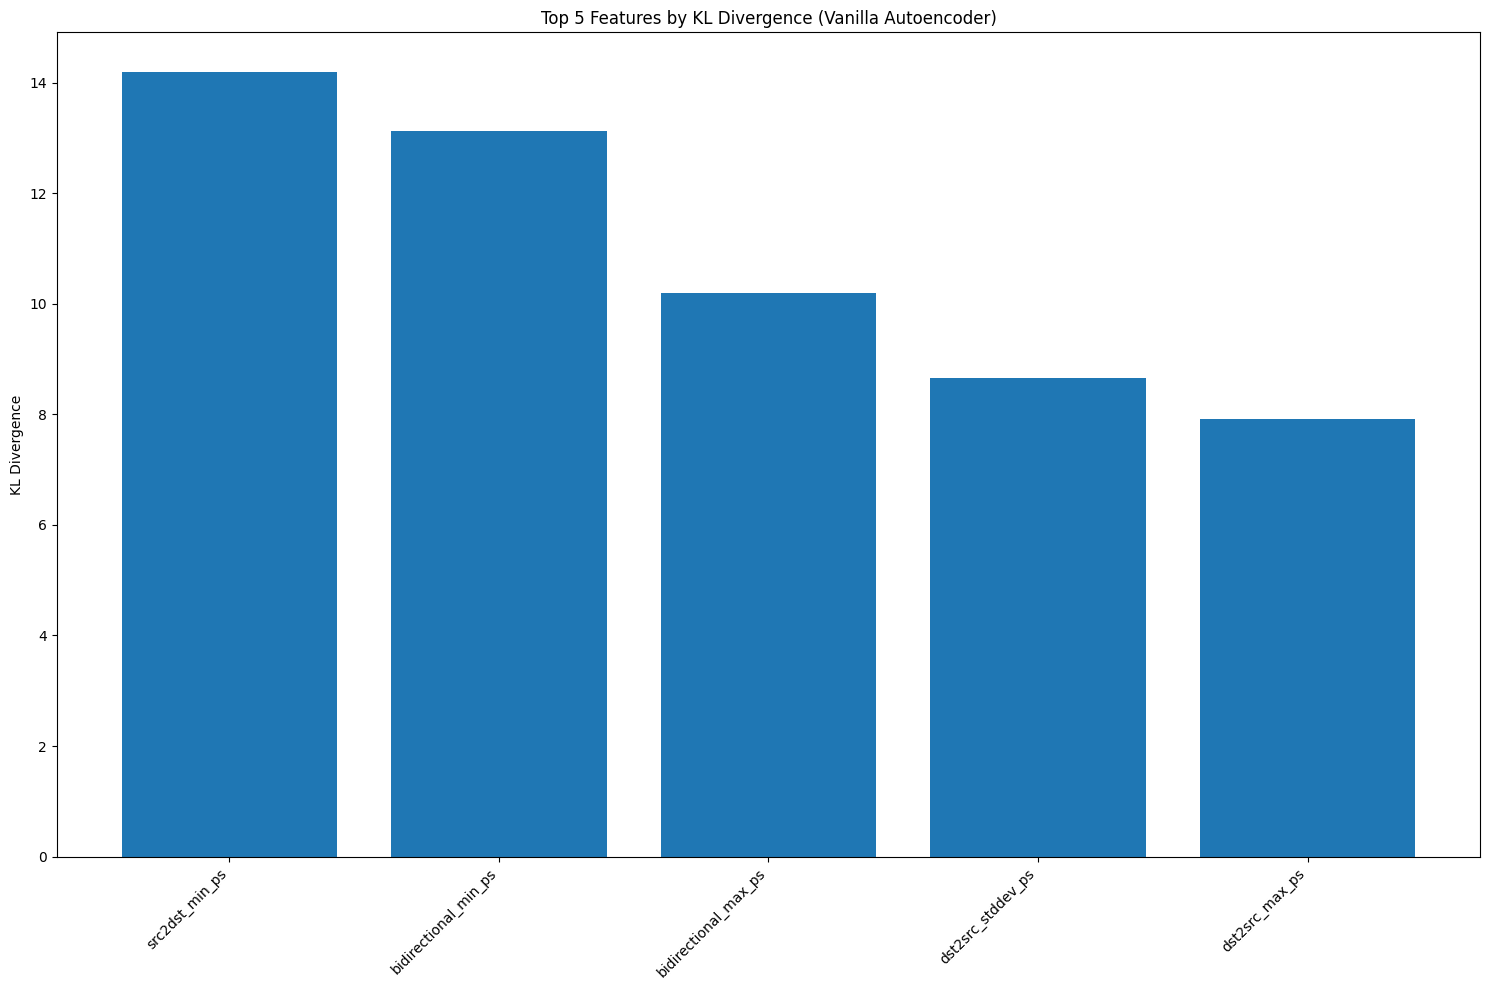

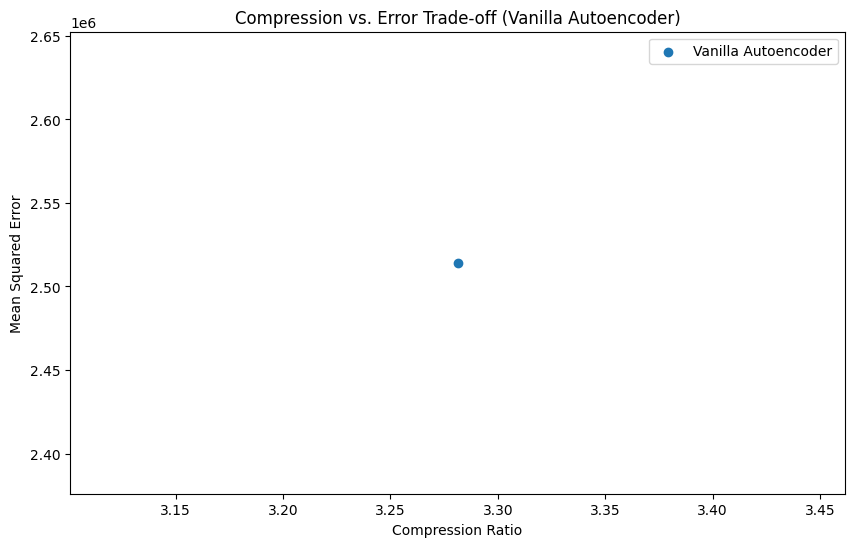

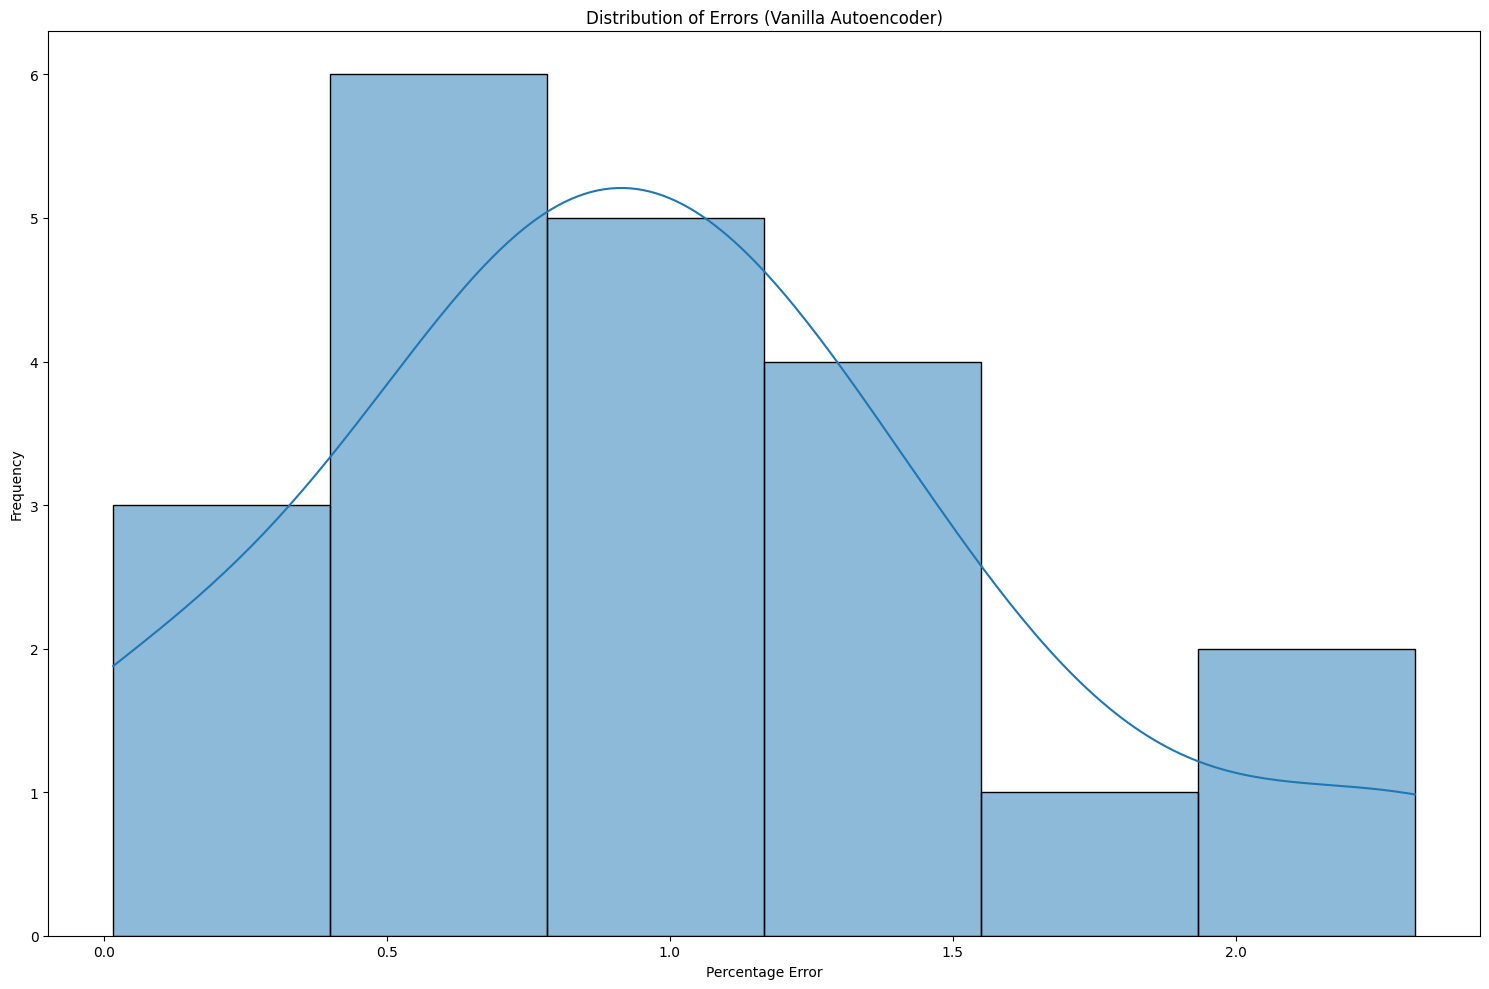

Visualization and analysis complete.


In [9]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from scipy.stats import entropy

def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.Generator().manual_seed(seed)

setup_seed(42)

# Base Autoencoder class
class BaseAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(BaseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, encoding_dim),
            nn.LeakyReLU(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            inputs = data[0]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            test_loss = sum(criterion(model(data[0]), data[0]).item() for data in test_loader) / len(test_loader)
        test_losses.append(test_loss)
        
        scheduler.step(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses, test_losses

# Load and preprocess data
df = pd.read_parquet('dataset.parquet')
compressible_features = [
    'bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes',
    'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
    'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
    'bidirectional_min_ps', 'bidirectional_mean_ps', 'bidirectional_stddev_ps', 'bidirectional_max_ps',
    'src2dst_min_ps', 'src2dst_mean_ps', 'src2dst_stddev_ps', 'src2dst_max_ps',
    'dst2src_min_ps', 'dst2src_mean_ps', 'dst2src_stddev_ps', 'dst2src_max_ps'
]

X = df[compressible_features].copy()

for column in X.columns:
    threshold = X[column].quantile(0.999)
    X.loc[:, column] = X[column].clip(upper=threshold)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True, 
                          worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=64, shuffle=False, 
                         worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))

# Train and evaluate vanilla autoencoder
print("\nTraining Vanilla Autoencoder")
input_dim = len(compressible_features)
encoding_dim = 16
model = BaseAutoencoder(input_dim, encoding_dim)

criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

num_epochs = 200
train_losses, test_losses = train_autoencoder(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs)

# Evaluate the model
model.eval()
with torch.no_grad():
    reconstructed_data = model(X_test_tensor).cpu().numpy()

# Inverse transform the data
reconstructed_data = scaler.inverse_transform(reconstructed_data)
X_test_original = scaler.inverse_transform(X_test)

# Calculate metrics
mse = np.mean((X_test_original - reconstructed_data) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((X_test_original - reconstructed_data) / (X_test_original + 1e-8))) * 100

# Compression ratio
original_size = X_scaled.nbytes
compressed_size = model.encoder(X_train_tensor).detach().cpu().numpy().nbytes
compression_ratio = original_size / compressed_size

# Feature-specific errors and KL divergences
feature_errors = {}
kl_divergences = {}
for i, feature in enumerate(compressible_features):
    percentage_error = np.median(np.abs((X_test_original[:, i] - reconstructed_data[:, i]) / (X_test_original[:, i] + 1e-8))) * 100
    feature_errors[feature] = float(percentage_error)

    original_hist, _ = np.histogram(X_test_original[:, i], bins=50, density=True)
    reconstructed_hist, _ = np.histogram(reconstructed_data[:, i], bins=50, density=True)
    original_hist = original_hist + 1e-10
    reconstructed_hist = reconstructed_hist + 1e-10
    kl_div = float(entropy(original_hist, reconstructed_hist))
    kl_divergences[feature] = kl_div

# Store results
results = {
    'vanilla': {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'mse': float(mse),
        'rmse': float(rmse),
        'mape': float(mape),
        'compression_ratio': float(compression_ratio),
        'feature_errors': feature_errors,
        'kl_divergences': kl_divergences
    }
}

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Compression Ratio: {compression_ratio:.2f}")

# Save results to JSON (excluding the model)
with open('autoencoder_results.json', 'w') as f:
    json.dump({k: {sk: sv for sk, sv in v.items() if sk != 'model'} for k, v in results.items()}, f, indent=4)

print("Results saved successfully to JSON.")

# Save the model using PyTorch's save function
torch.save(results['vanilla']['model'].state_dict(), 'vanilla_model.pth')
print("Model saved successfully.")

# Save scaler
joblib.dump(scaler, 'robust_scaler.joblib')

# Save feature names
with open('feature_names.json', 'w') as f:
    json.dump(compressible_features, f)

print("Scaler and feature names saved successfully.")

# Visualizations

# 1. Training and Test Loss
plt.figure(figsize=(10, 6))
plt.plot(results['vanilla']['train_losses'], label='Train Loss')
plt.plot(results['vanilla']['test_losses'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Vanilla Autoencoder: Training and Test Loss')
plt.legend()
plt.savefig('vanilla_autoencoder_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparison of performance metrics
metrics = ['mse', 'rmse', 'mape', 'compression_ratio']
comparison_data = {metric: [results['vanilla'][metric]] for metric in metrics}
comparison_df = pd.DataFrame(comparison_data, index=['vanilla'])

plt.figure(figsize=(12, 8))
comparison_df.plot(kind='bar')
plt.title('Vanilla Autoencoder Performance')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Feature-specific error comparisons
feature_errors_df = pd.DataFrame(results['vanilla']['feature_errors'], index=[0]).transpose()
plt.figure(figsize=(15, 10))
sns.heatmap(feature_errors_df, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Feature-specific Percentage Errors for Vanilla Autoencoder')
plt.ylabel('Features')
plt.xlabel('Vanilla Autoencoder')
plt.tight_layout()
plt.show()

# KL divergence comparisons
kl_divergences_df = pd.DataFrame(results['vanilla']['kl_divergences'], index=[0]).transpose()
plt.figure(figsize=(15, 10))
sns.heatmap(kl_divergences_df, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('KL Divergences for Vanilla Autoencoder')
plt.ylabel('Features')
plt.xlabel('Vanilla Autoencoder')
plt.tight_layout()
plt.show()

# Correlation heatmaps
def calculate_correlation_matrix(data):
    return np.corrcoef(data.T)

model = results['vanilla']['model']
model.eval()
with torch.no_grad():
    reconstructed_data = model(X_test_tensor).cpu().numpy()

# Inverse transform the data
reconstructed_data = scaler.inverse_transform(reconstructed_data)
X_test_original = scaler.inverse_transform(X_test)

# Calculate correlation matrices
original_corr = calculate_correlation_matrix(X_test_original)
reconstructed_corr = calculate_correlation_matrix(reconstructed_data)
diff_corr = original_corr - reconstructed_corr

# Plot correlation difference heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(diff_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            xticklabels=compressible_features, yticklabels=compressible_features)
# plt.title('Correlation Difference: Original - Reconstructed (Vanilla Autoencoder)')
plt.tight_layout()
plt.savefig('correlation_difference.png', dpi=300, bbox_inches='tight')
plt.show()

# Original vs Reconstructed Scatter Plots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
sample_features = ['bidirectional_packets', 'bidirectional_bytes', 'src2dst_duration_ms', 'dst2src_packets']
for i, feature in enumerate(sample_features):
    ax = axes[i // 2, i % 2]
    feature_index = compressible_features.index(feature)
    ax.scatter(X_test_original[:, feature_index], reconstructed_data[:, feature_index], alpha=0.5)
    ax.plot([X_test_original[:, feature_index].min(), X_test_original[:, feature_index].max()], 
            [X_test_original[:, feature_index].min(), X_test_original[:, feature_index].max()], 
            'r--', lw=2)
    ax.set_xlabel('Original')
    ax.set_ylabel('Reconstructed')
    ax.set_title(f'Original vs Reconstructed: {feature}')
plt.tight_layout()
plt.show()

# Comparison of top features by importance (based on error and KL divergence)
def get_top_features(data, n=5):
    return sorted(data.items(), key=lambda x: x[1], reverse=True)[:n]

plt.figure(figsize=(15, 10))
top_errors = get_top_features(results['vanilla']['feature_errors'])
features, errors = zip(*top_errors)
plt.bar(features, errors)
plt.title('Top 5 Features by Error (Vanilla Autoencoder)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage Error')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
top_kl = get_top_features(results['vanilla']['kl_divergences'])
features, kl_divs = zip(*top_kl)
plt.bar(features, kl_divs)
plt.title('Top 5 Features by KL Divergence (Vanilla Autoencoder)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('KL Divergence')
plt.tight_layout()
plt.show()

# Comparison of compression vs. error trade-off
plt.figure(figsize=(10, 6))
plt.scatter(results['vanilla']['compression_ratio'], results['vanilla']['mse'], label='Vanilla Autoencoder')
plt.xlabel('Compression Ratio')
plt.ylabel('Mean Squared Error')
plt.title('Compression vs. Error Trade-off (Vanilla Autoencoder)')
plt.legend()
plt.show()

# Distribution of errors across features
plt.figure(figsize=(15, 10))
errors = list(results['vanilla']['feature_errors'].values())
sns.histplot(errors, kde=True)
plt.title('Distribution of Errors (Vanilla Autoencoder)')
plt.xlabel('Percentage Error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# # Utility function to load the model (if needed later)
# def load_model(input_dim, encoding_dim):
#     model = BaseAutoencoder(input_dim, encoding_dim)
#     model.load_state_dict(torch.load('vanilla_model.pth'))
#     model.eval()
#     return model

# # Example of how to use the load_model function:
# loaded_vanilla_model = load_model(input_dim, encoding_dim)

print("Visualization and analysis complete.")

/var/folders/26/m1ty4dhn4kd02qvztlq5pdlh0000gp/T/ipykernel_11611/2417889498.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)


Classification Report - Original Features:
                precision    recall  f1-score   support

    BitTorrent       1.00      1.00      1.00     68848
       Discord       1.00      1.00      1.00     33217
          HTTP       1.00      1.00      1.00     60675
QUIC.Instagram       1.00      1.00      1.00     26645
  QUIC.YouTube       1.00      1.00      1.00    130105
           RDP       1.00      1.00      1.00     21566
          STUN       1.00      1.00      1.00     31009
  TLS.Facebook       0.99      0.99      0.99     64216
    TLS.TikTok       1.00      1.00      1.00    181713
      WhatsApp       1.00      0.99      0.99     14699

      accuracy                           1.00    632693
     macro avg       1.00      1.00      1.00    632693
  weighted avg       1.00      1.00      1.00    632693

Accuracy - Original Features: 0.9977

Classification Report - Vanilla AE Compressed Features:
                precision    recall  f1-score   support

    BitTorrent    

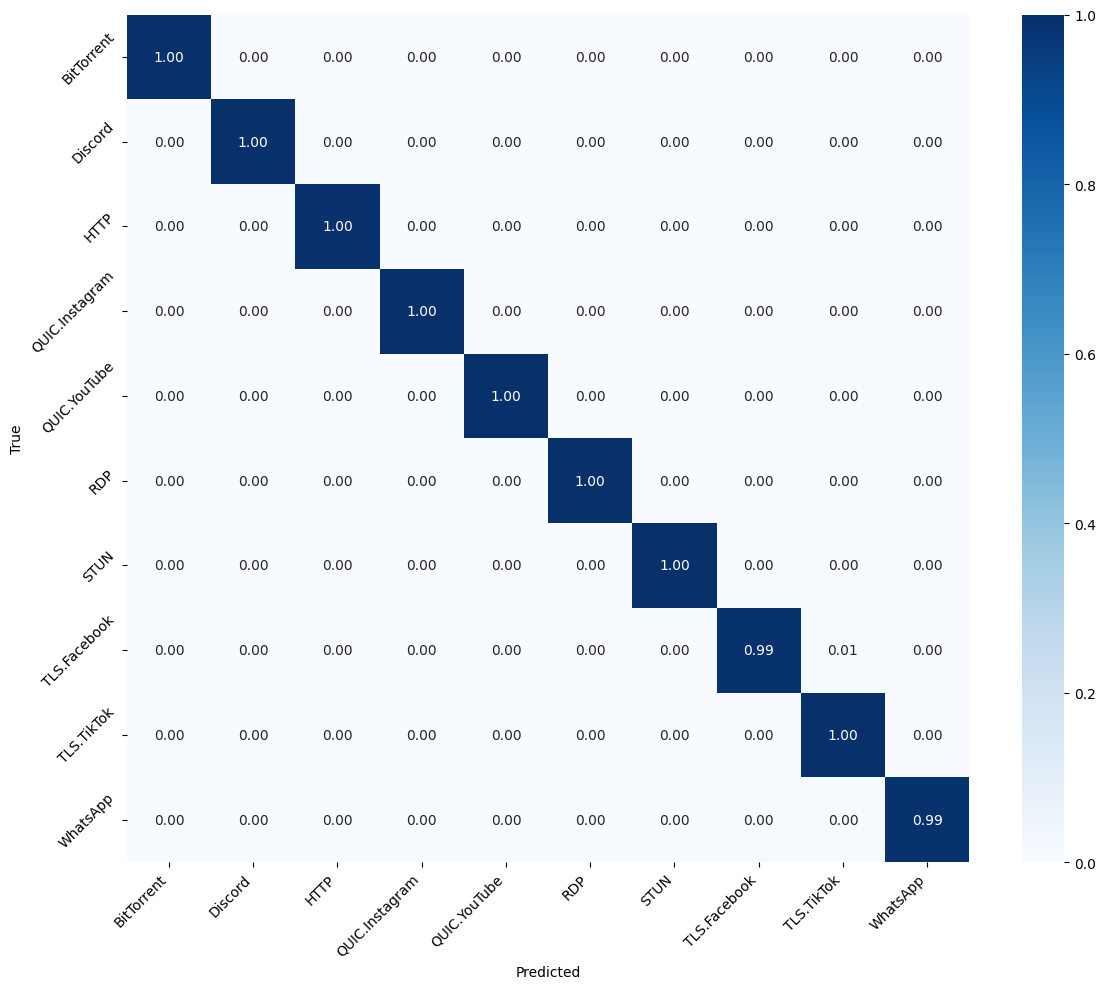

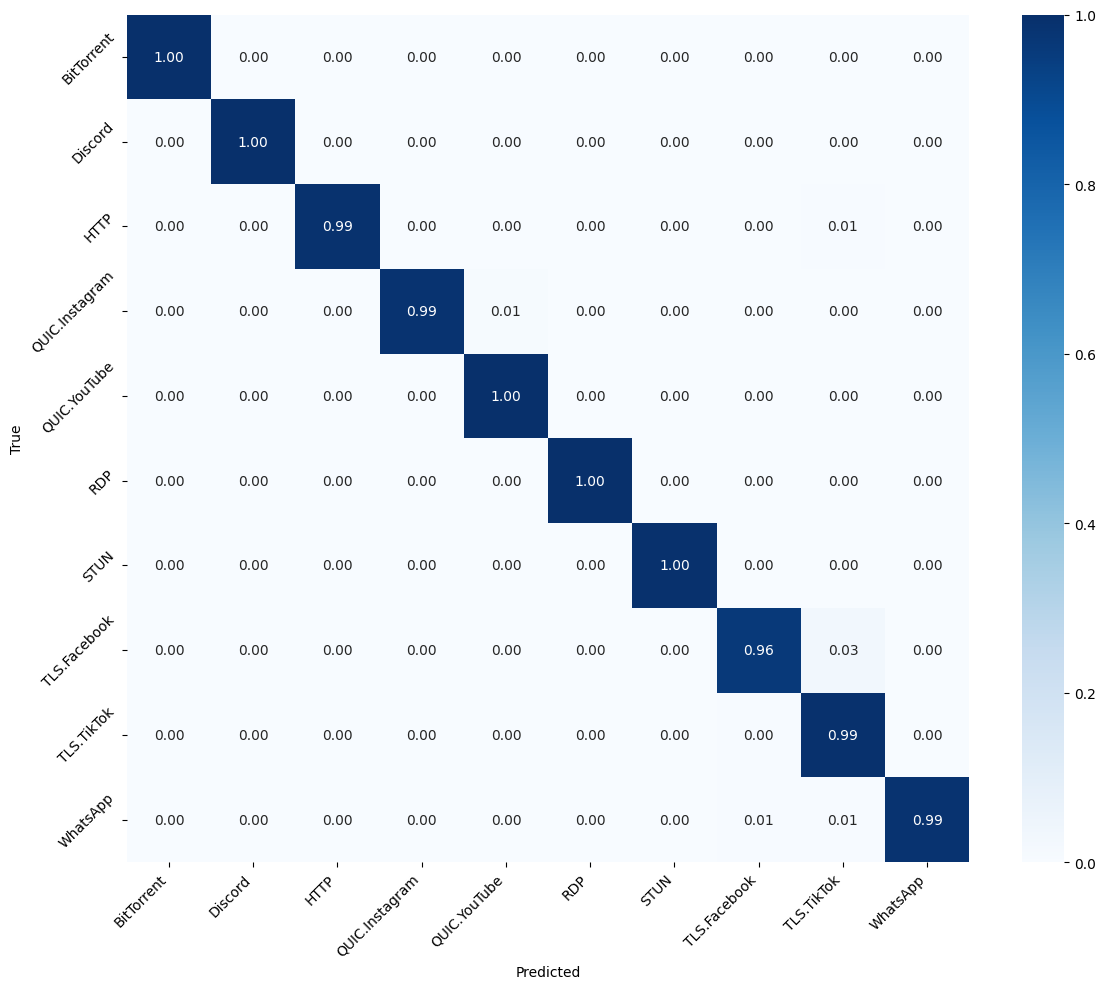

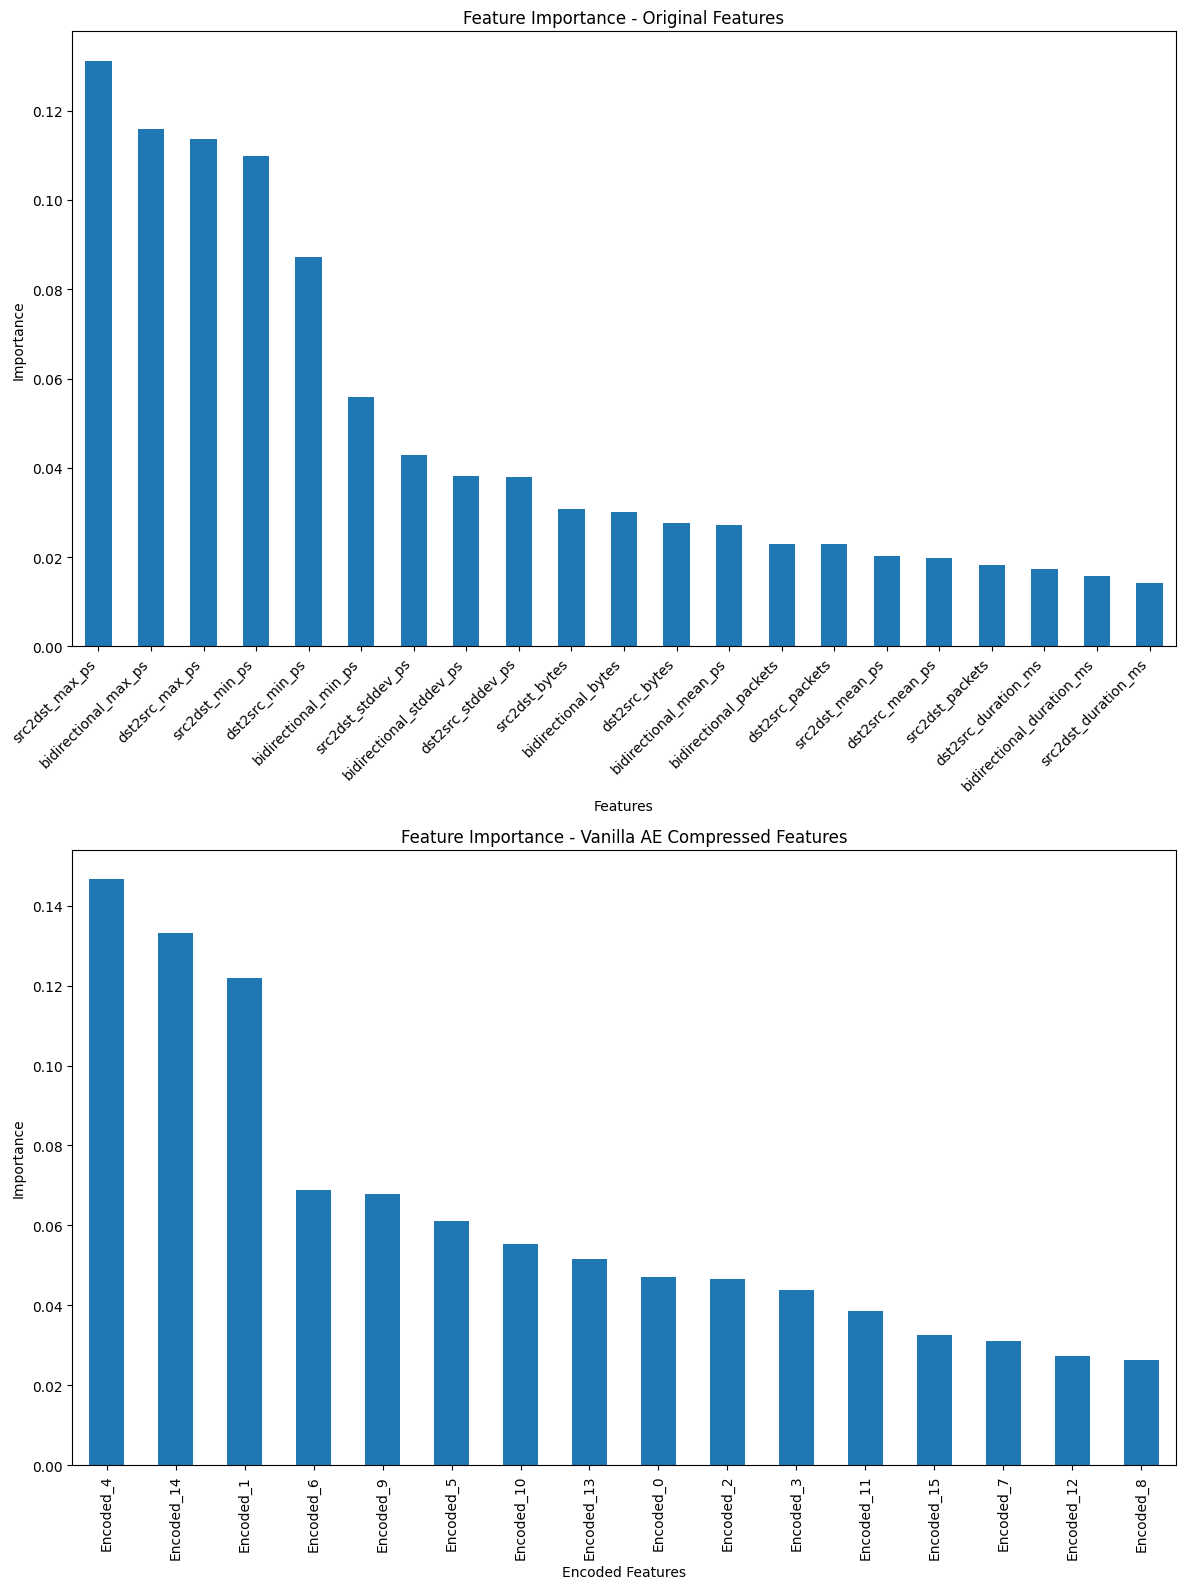

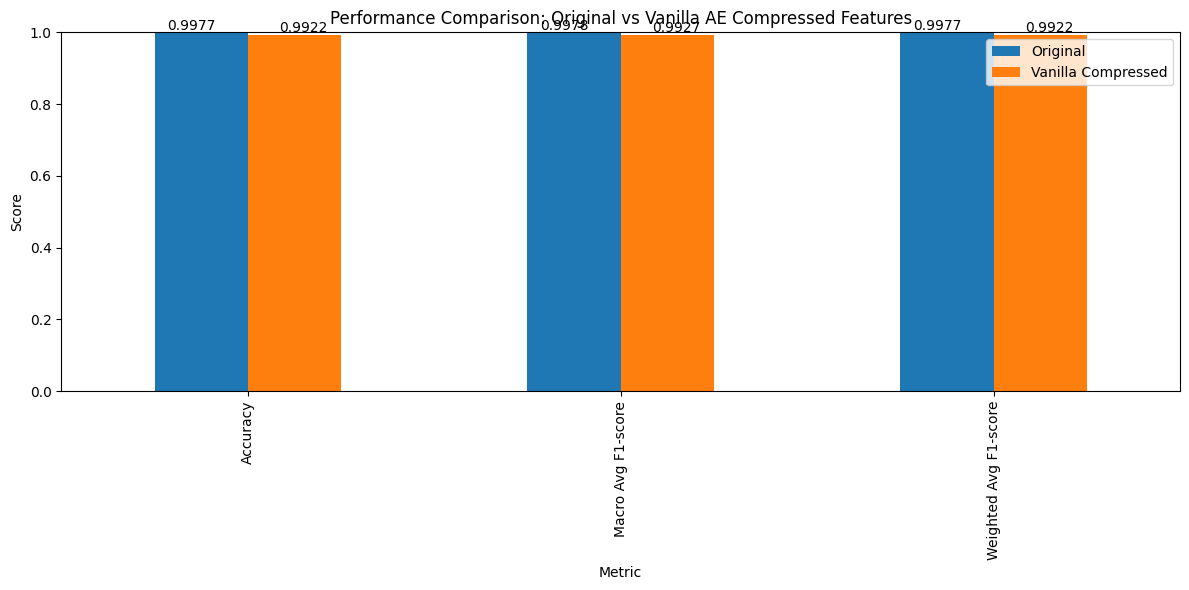

In [8]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the autoencoder models and related data
def load_autoencoder(model_path, input_dim, encoding_dim):
    class Autoencoder(torch.nn.Module):
        def __init__(self, input_dim, encoding_dim):
            super(Autoencoder, self).__init__()
            self.encoder = torch.nn.Sequential(
                torch.nn.Linear(input_dim, 128),
                torch.nn.LeakyReLU(0.2),
                torch.nn.Linear(128, 64),
                torch.nn.LeakyReLU(0.2),
                torch.nn.Linear(64, encoding_dim),
                torch.nn.LeakyReLU(0.2)
            )
            self.decoder = torch.nn.Sequential(
                torch.nn.Linear(encoding_dim, 64),
                torch.nn.LeakyReLU(0.2),
                torch.nn.Linear(64, 128),
                torch.nn.LeakyReLU(0.2),
                torch.nn.Linear(128, input_dim)
            )
        
        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    model = Autoencoder(input_dim, encoding_dim)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load models
with open('feature_names.json', 'r') as f:
    compressible_features = json.load(f)

input_dim = len(compressible_features)
encoding_dim = 16  # This must match what we used in training

vanilla_model = load_autoencoder('vanilla_model.pth', input_dim, encoding_dim)

# Load the scaler
scaler = joblib.load('robust_scaler.joblib')

# Load and preprocess the data
df = pd.read_parquet('dataset.parquet')
X = df[compressible_features].copy()
y = df['application_name']

# Remove extreme outliers (values beyond 99.9th percentile)
for column in X.columns:
    threshold = X[column].quantile(0.999)
    X.loc[:, column] = X[column].clip(upper=threshold)

# Scale the features
X_scaled = scaler.transform(X)

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Generate compressed features
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

with torch.no_grad():
    X_train_compressed_vanilla = vanilla_model.encoder(X_train_tensor).numpy()
    X_test_compressed_vanilla = vanilla_model.encoder(X_test_tensor).numpy()

# Function to train and evaluate Random Forest
def evaluate_rf(X_train, X_test, y_train, y_test, feature_type):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    print(f"\nClassification Report - {feature_type} Features:")
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    print(f"Accuracy - {feature_type} Features: {accuracy_score(y_test, y_pred):.4f}")
    
    return rf, y_pred, report

# Evaluate models
rf_original, y_pred_original, original_report = evaluate_rf(X_train, X_test, y_train, y_test, "Original")
rf_vanilla, y_pred_vanilla, vanilla_report = evaluate_rf(X_train_compressed_vanilla, X_test_compressed_vanilla, y_train, y_test, "Vanilla AE Compressed")

# Prepare results for storage
results = {
    "original_features": {
        "classification_report": original_report,
        "accuracy": float(accuracy_score(y_test, y_pred_original))
    },
    "vanilla_compressed_features": {
        "classification_report": vanilla_report,
        "accuracy": float(accuracy_score(y_test, y_pred_vanilla))
    },
    "misclassification_analysis": {
        "original_misclassifications": int(np.sum(y_test != y_pred_original)),
        "vanilla_compressed_misclassifications": int(np.sum(y_test != y_pred_vanilla)),
        "common_misclassifications": int(np.sum((y_test != y_pred_original) & (y_test != y_pred_vanilla)))
    },
    "top_misclassified_classes": {
        "original": {k: int(v) for k, v in pd.Series(le.inverse_transform(y_test[y_test != y_pred_original])).value_counts().head().items()},
        "vanilla_compressed": {k: int(v) for k, v in pd.Series(le.inverse_transform(y_test[y_test != y_pred_vanilla])).value_counts().head().items()}
    },
    "normalized_confusion_matrices": {
        "original": confusion_matrix(y_test, y_pred_original, normalize='true').tolist(),
        "vanilla_compressed": confusion_matrix(y_test, y_pred_vanilla, normalize='true').tolist()
    }
}

# Save results to JSON
with open('classification_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\nResults have been saved to 'classification_results.json'")

# Print overall comparison
performance_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Macro Avg F1-score', 'Weighted Avg F1-score'],
    'Original': [
        results['original_features']['accuracy'],
        results['original_features']['classification_report']['macro avg']['f1-score'],
        results['original_features']['classification_report']['weighted avg']['f1-score']
    ],
    'Vanilla Compressed': [
        results['vanilla_compressed_features']['accuracy'],
        results['vanilla_compressed_features']['classification_report']['macro avg']['f1-score'],
        results['vanilla_compressed_features']['classification_report']['weighted avg']['f1-score']
    ]
})
performance_comparison.set_index('Metric', inplace=True)
print("\nOverall Comparison:")
print(performance_comparison)

# Print misclassification analysis
print("\nMisclassification Analysis:")
print(f"Total misclassifications - Original: {results['misclassification_analysis']['original_misclassifications']}")
print(f"Total misclassifications - Vanilla Compressed: {results['misclassification_analysis']['vanilla_compressed_misclassifications']}")
print(f"Common misclassifications: {results['misclassification_analysis']['common_misclassifications']}")

print("\nTop 5 most misclassified classes:")
for feature_type in ['original', 'vanilla_compressed']:
    print(f"\n{feature_type.capitalize()} Features:")
    for class_name, count in results['top_misclassified_classes'][feature_type].items():
        print(f"{class_name}: {count}")

# Visualizations
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
    # plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{title}.png', dpi=300, bbox_inches='tight')
    plt.show()

# 1. Confusion Matrices
# for feature_type in ['original', 'vanilla_compressed']:
#     plot_confusion_matrix(np.array(results['confusion_matrices'][feature_type]), le.classes_, f'Confusion Matrix - {feature_type.capitalize()} Features')

# Plot normalized confusion matrices
for feature_type in ['original', 'vanilla_compressed']:
    plot_confusion_matrix(np.array(results['normalized_confusion_matrices'][feature_type]), 
                          le.classes_, 
                          f'Normalized Confusion Matrix - {feature_type.capitalize()} Features')

# 2. Feature Importance Comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

feature_importance_original = pd.Series(rf_original.feature_importances_, index=compressible_features)
feature_importance_original.sort_values(ascending=False).plot(kind='bar', ax=ax1)
ax1.set_title('Feature Importance - Original Features')
ax1.set_xlabel('Features')
ax1.set_ylabel('Importance')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

feature_importance_vanilla = pd.Series(rf_vanilla.feature_importances_, index=[f'Encoded_{i}' for i in range(encoding_dim)])
feature_importance_vanilla.sort_values(ascending=False).plot(kind='bar', ax=ax2)
ax2.set_title('Feature Importance - Vanilla AE Compressed Features')
ax2.set_xlabel('Encoded Features')
ax2.set_ylabel('Importance')

plt.tight_layout()
plt.show()

# 3. Performance Comparison
fig, ax = plt.subplots(figsize=(12, 6))
performance_comparison.plot(kind='bar', ax=ax)
plt.title('Performance Comparison: Original vs Vanilla AE Compressed Features')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, (index, row) in enumerate(performance_comparison.iterrows()):
    plt.text(i-0.15, row['Original'], f"{row['Original']:.4f}", ha='center', va='bottom')
    plt.text(i+0.15, row['Vanilla Compressed'], f"{row['Vanilla Compressed']:.4f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()